# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Иследовательский анализ

In [2]:
# Загрузим необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# загрузим данные

data = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
# ПОсмотрим общую информацию 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


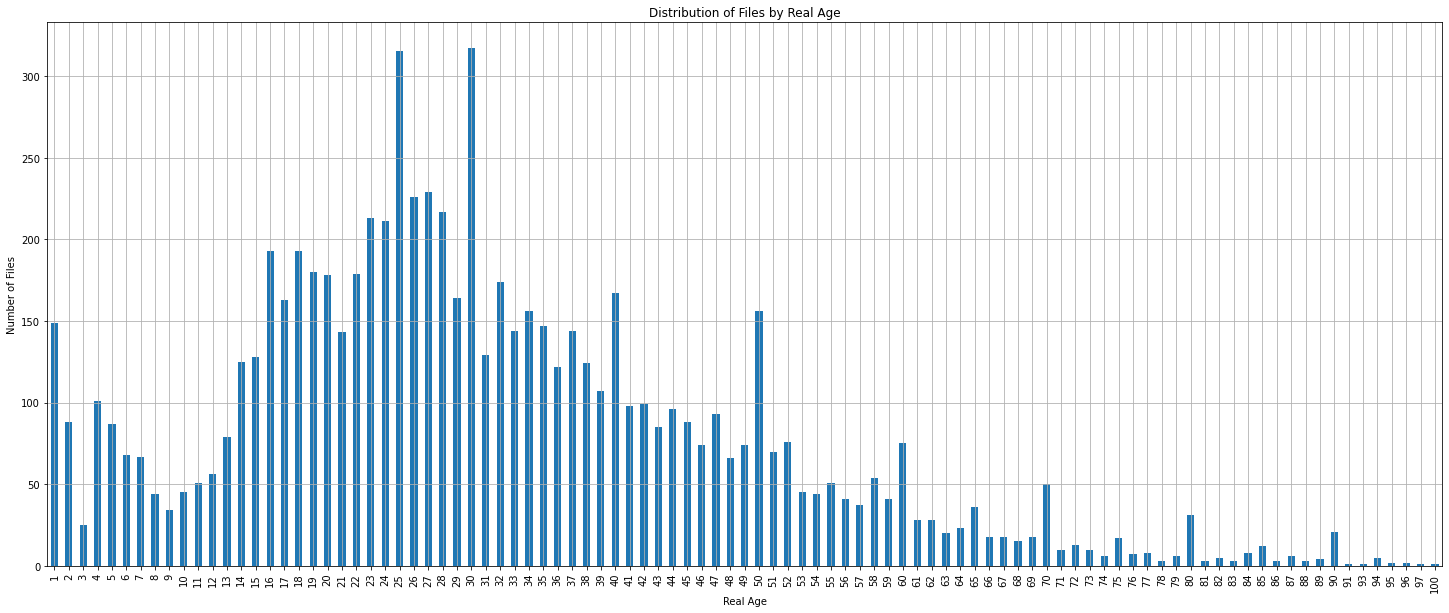

In [4]:
# Сгруппируем данные по возрасту и подсчет количества файлов

age_counts = data['real_age'].value_counts().sort_index()

# Построим график распределения

plt.figure(figsize=(25,10))
           
age_counts.plot(kind='bar')
plt.title('Distribution of Files by Real Age')
plt.xlabel('Real Age')
plt.ylabel('Number of Files')
plt.grid(True)
plt.show()

Размер изображения:  (835, 835, 3)
Возраст:  59


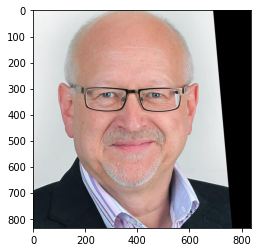

Размер изображения:  (381, 381, 3)
Возраст:  23


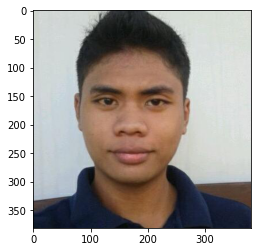

Размер изображения:  (138, 138, 3)
Возраст:  2


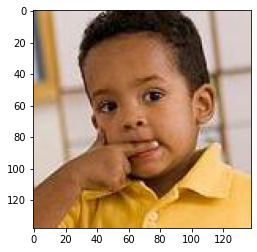

Размер изображения:  (109, 109, 3)
Возраст:  25


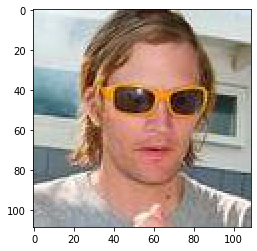

Размер изображения:  (114, 114, 3)
Возраст:  4


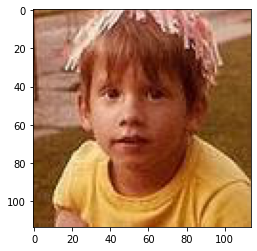

Размер изображения:  (370, 370, 3)
Возраст:  50


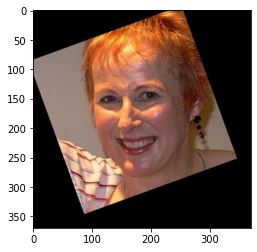

Размер изображения:  (69, 69, 3)
Возраст:  10


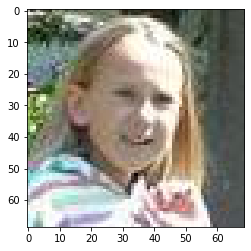

Размер изображения:  (140, 141, 3)
Возраст:  28


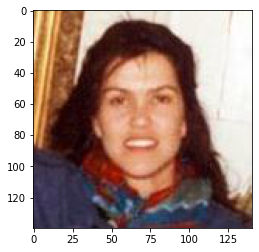

Размер изображения:  (898, 897, 3)
Возраст:  26


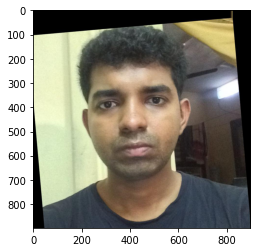

Размер изображения:  (169, 168, 3)
Возраст:  5


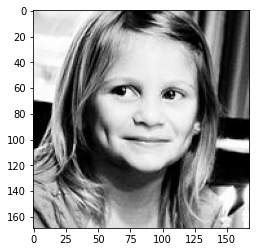

Размер изображения:  (1658, 1657, 3)
Возраст:  30


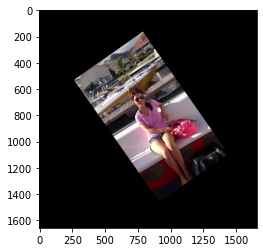

Размер изображения:  (636, 636, 3)
Возраст:  17


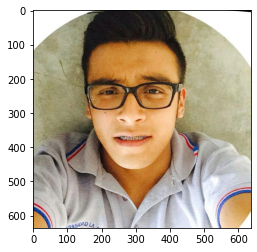

Размер изображения:  (404, 404, 3)
Возраст:  1


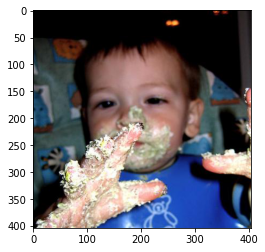

Размер изображения:  (344, 345, 3)
Возраст:  24


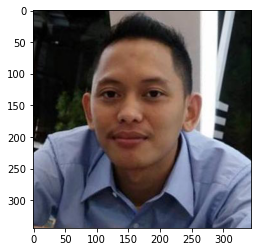

Размер изображения:  (242, 241, 3)
Возраст:  25


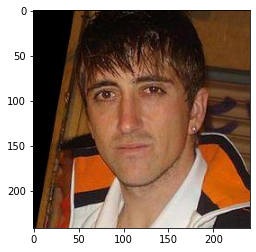

In [5]:
# выведем 15 фотографий с размерамси и возрастом

rand = random.sample(range(100),15)

for i in rand:
    if i < 10:
        number = '0' + str(i)
    else:
        number = i
        
    image = np.array(Image.open(f'/datasets/faces/final_files/0000{number}.jpg'))
    
    print('Размер изображения: ', image.shape)
    print('Возраст: ', data.loc[i,'real_age'])
    
    plt.imshow(image)
    plt.show()

### Вывод

В датасете 7591 фотографий разного размера. БОльшая часть фотографий соответствует возрастному диапозону 14-52 (примерно).
Фотографии разного качества, разного размера, разного расположения лиц( некоторые под углом) - думаю, сильного переобучения не будет

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


import numpy as np


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
2023-08-13 10:41:15.260379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-13 10:41:15.700611: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 128s - loss: 195.9300 - mae: 10.5946 - val_loss: 419.1247 - val_mae: 15.4622
Epoch 2/15
356/356 - 43s - loss: 99.2047 - mae: 7.5979 - val_loss: 229.2822 - val_mae: 11.2099
Epoch 3/15
356/356 - 42s - loss: 62.4905 - mae: 6.0672 - val_loss: 91.0101 - val_mae: 7.4347
Epoch 4/15
356/356 - 42s - loss: 42.2876 - mae: 5.0403 - val_loss: 91.9405 - val_mae: 7.3136
Epoch 5/15
356/356 - 43s - loss: 31.2778 - mae: 4.3261 - val_loss: 106.9005 - val_mae: 7.6450
Epoch 6/15
356/356 - 42s - loss: 20.9265 - mae: 3.5323 - val_loss: 84.7368 - val_mae: 7.0332
Epoch 7/15
356/356 - 43s - loss: 16.3483 - mae: 3.1092 - val_loss: 81.7145 - val_mae: 6.9903
Epoch 8/15
356/356 - 42s - loss: 14.6248 - mae: 2.9079 - val_loss: 70.9413 - val_mae: 6.3245
Epoch 9/15
356/356 - 43s - loss: 13.0765 - mae: 2.7598 - val_loss: 75.0684 - val_mae: 6.5161
Epoch 10/15
356/356 - 42s - loss: 12.6003 - mae: 2.7068 - val_loss: 107.8869 - val_mae: 8.2927
Epoch 11/15
356/356 - 43s - loss: 12.4367 - mae: 2.6626 - val_loss: 82.2364 - val_mae: 6.9941
Epoch 12/15
356/356 - 43s - loss: 12.8934 - mae: 2.7304 - val_loss: 85.8330 - val_mae: 6.7643
Epoch 13/15
356/356 - 43s - loss: 15.1865 - mae: 2.9578 - val_loss: 93.3006 - val_mae: 7.6615
Epoch 14/15
356/356 - 44s - loss: 16.4503 - mae: 3.0656 - val_loss: 80.5577 - val_mae: 6.8205
Epoch 15/15
356/356 - 45s - loss: 15.5900 - mae: 3.0050 - val_loss: 80.8877 - val_mae: 6.8875
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 80.8877 - mae: 6.8875
Test MAE: 6.8875
```

## Анализ обученной модели

В рамках данного проекта мы иследовали возможность определения возраста покупателей с помощью нейросети для решения двух задач:
- Анализ покупок и предложение товаров, которые могут заинтересовать покупателей этой возрастной группы;
- Контроль добросовестности кассиров при продаже алкоголя.

Мы использовали нейронную сеть ResNet глубиной в 50 слоев.

ОБучали нейросеть на 15 эпохах.

Лучший результат был достигнут на 8 эпохе - 6.3245 - поставленная цель достигнута.
ПОтому в итоговом коде кол-во эпох было ументшено до 8.

Иными словами, наша модель ошибается в среднем на 6,3 года.



Исходя из этого, не могу рекомендовать нейросеть в качестве полной замены человеческого контроля, можно использовать ее для обращения внимания на подозрительные случаи. 

При этом, рекомендовать товары с "подсказками" нашей сети - можно. Еще лучше было бы категоризировать итоговый результат: разбить всех покупателей на возрастные группы.

